# Criminal Revicidation

We will do some data analysis and predict whether the criminal will recidivate in the future (in next 2 years)?

In [1]:
# Import all of the modules we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import random as rand
import itertools
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

# Data Preliminary Observations

In [2]:
data = pd.read_csv("recidivism_full.csv")  # Load in the downloaded csv file 

In [3]:
# remove the sample division column
df = data.iloc[:, 1:-1]
df

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
0,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,Drug,...,0.0,0.000000,0.0,0.488562,0.447610,False,False,False,False,False
1,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,Violent/Non-Sex,...,0.0,0.000000,0.0,0.425234,2.000000,False,True,False,False,True
2,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,Drug,...,0.0,0.166667,0.0,0.000000,0.000000,False,True,False,True,False
3,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,Property,...,0.0,0.000000,0.0,1.000000,0.718996,False,False,False,False,False
4,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,Violent/Non-Sex,...,0.0,0.058824,0.0,0.203562,0.929389,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25830,M,BLACK,23-27,9,False,5.0,Standard,At least some college,1,NaN,...,0.0,0.000000,0.0,0.189507,0.572044,False,True,True,False,False
25831,M,WHITE,38-42,25,False,5.0,Standard,At least some college,3 or more,NaN,...,0.0,0.000000,0.0,0.757098,0.576104,False,True,False,True,False
25832,M,BLACK,33-37,15,False,5.0,Standard,At least some college,3 or more,NaN,...,NaN,NaN,NaN,0.711138,0.894125,False,True,False,True,False
25833,F,WHITE,33-37,15,NaN,5.0,Standard,At least some college,3 or more,NaN,...,0.0,0.000000,0.0,0.000000,0.000000,True,False,False,False,False


In [4]:
# list of each columns together with its datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25835 entries, 0 to 25834
Data columns (total 52 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Gender                                             25835 non-null  object 
 1   Race                                               25835 non-null  object 
 2   Age_at_Release                                     25835 non-null  object 
 3   Residence_PUMA                                     25835 non-null  int64  
 4   Gang_Affiliated                                    22668 non-null  object 
 5   Supervision_Risk_Score_First                       25360 non-null  float64
 6   Supervision_Level_First                            24115 non-null  object 
 7   Education_Level                                    25835 non-null  object 
 8   Dependents                                         25835 non-null  object 
 9   Prison

In [5]:
# Number of Missing Values
df.isnull().sum()[df.isnull().sum() != 0]

Gang_Affiliated                 3167
Supervision_Risk_Score_First     475
Supervision_Level_First         1720
Prison_Offense                  3277
Avg_Days_per_DrugTest           6103
DrugTests_THC_Positive          5172
DrugTests_Cocaine_Positive      5172
DrugTests_Meth_Positive         5172
DrugTests_Other_Positive        5172
Percent_Days_Employed            462
Jobs_Per_Year                    808
dtype: int64

In [6]:
# Columns with more than 50% missing values, which we won't use in our analysis
df[df.columns[df.isnull().sum()>0.5*len(df)]].columns

Index([], dtype='object')

In [7]:
print(df.shape)
df.describe()

(25835, 52)


,Residence_PUMA,Supervision_Risk_Score_First,Avg_Days_per_DrugTest,DrugTests_THC_Positive,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year
count,25835.000000,25360.000000,19732.000000,20663.000000,20663.000000,20663.000000,20663.00000,25373.000000,25027.000000
mean,12.361796,6.082216,93.890044,0.063350,0.013741,0.012890,0.00755,0.482331,0.769295
std,7.133742,2.381442,117.169847,0.138453,0.061233,0.060581,0.04115,0.425004,0.813787
min,1.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,6.000000,4.000000,28.837366,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,12.000000,6.000000,55.424812,0.000000,0.000000,0.000000,0.00000,0.475728,0.635217
75%,18.000000,8.000000,110.333333,0.071429,0.000000,0.000000,0.00000,0.969325,1.000000
max,25.000000,10.000000,1088.500000,1.000000,1.000000,1.000000,1.00000,1.000000,8.000000


In [8]:
df.Prison_Offense.value_counts()

Property           8284
Violent/Non-Sex    5475
Drug               5190
Other              2779
Violent/Sex         830
Name: Prison_Offense, dtype: int64

In [9]:
# fill median in Avg_Days_per_DrugTest/Percent_Days_Employed/Jobs_Per_Year/Supervision_Risk_Score_First
# fill other in Prison_Offense
df.Avg_Days_per_DrugTest.fillna(df.Avg_Days_per_DrugTest.median(), inplace=True)
df.loc[(df.Prison_Offense.isna()), 'Prison_Offense'] = 'Other'
df.Percent_Days_Employed.fillna(df.Percent_Days_Employed.median(), inplace=True)
df.Jobs_Per_Year.fillna(df.Jobs_Per_Year.median(), inplace=True)
df.Supervision_Risk_Score_First.fillna(df.Supervision_Risk_Score_First.median(), inplace=True)
df.isnull().sum()[df.isnull().sum() != 0]

Gang_Affiliated               3167
Supervision_Level_First       1720
DrugTests_THC_Positive        5172
DrugTests_Cocaine_Positive    5172
DrugTests_Meth_Positive       5172
DrugTests_Other_Positive      5172
dtype: int64

In [10]:
# fill NA value with mode
df.Gang_Affiliated.fillna(df.Gang_Affiliated.mode()[0], inplace=True)
df.DrugTests_THC_Positive.fillna(df.DrugTests_THC_Positive.mode()[0], inplace=True)
df.DrugTests_Cocaine_Positive.fillna(df.DrugTests_Cocaine_Positive.mode()[0], inplace=True)
df.DrugTests_Meth_Positive.fillna(df.DrugTests_Meth_Positive.mode()[0], inplace=True)
df.DrugTests_Other_Positive.fillna(df.DrugTests_Other_Positive.mode()[0], inplace=True)
df.isnull().sum()[df.isnull().sum() != 0]

Supervision_Level_First    1720
dtype: int64

In [11]:
a = pd.DataFrame(df.loc[:, ['Supervision_Risk_Score_First', 'Supervision_Level_First']].value_counts())
a = a.reset_index()
a.columns = ['Supervision_Risk_Score_First', 'Supervision_Level_First', 'count']
a.sort_values(['Supervision_Risk_Score_First', 'count'], ascending = False)
b = a.sort_values(['Supervision_Risk_Score_First', 'count'], ascending = False).drop_duplicates(subset=['Supervision_Risk_Score_First'], keep = 'first')
b

,Supervision_Risk_Score_First,Supervision_Level_First,count
6,10.0,Specialized,1890
3,9.0,Specialized,2045
5,8.0,High,1908
2,7.0,High,2265
1,6.0,High,2420
0,5.0,Standard,2590
4,4.0,Standard,1980
7,3.0,Standard,1423
9,2.0,Standard,762
15,1.0,Standard,484


In [12]:
# fill NA value in Supervision_Level_First with mode in same Supervision_Risk_Score_First value
c = df.loc[df.Supervision_Level_First.isna(), ['Supervision_Risk_Score_First', 'Supervision_Level_First']]
for i in range(len(c)):
    index = c.index[i]
    value = b.loc[(b.Supervision_Risk_Score_First == c.iloc[i, 0]), :].iloc[:, 1].values[0]
    df.Supervision_Level_First[index] = value

In [13]:
df.isnull().sum()[df.isnull().sum() != 0]

Series([], dtype: int64)

# Data Visualization

<AxesSubplot: >

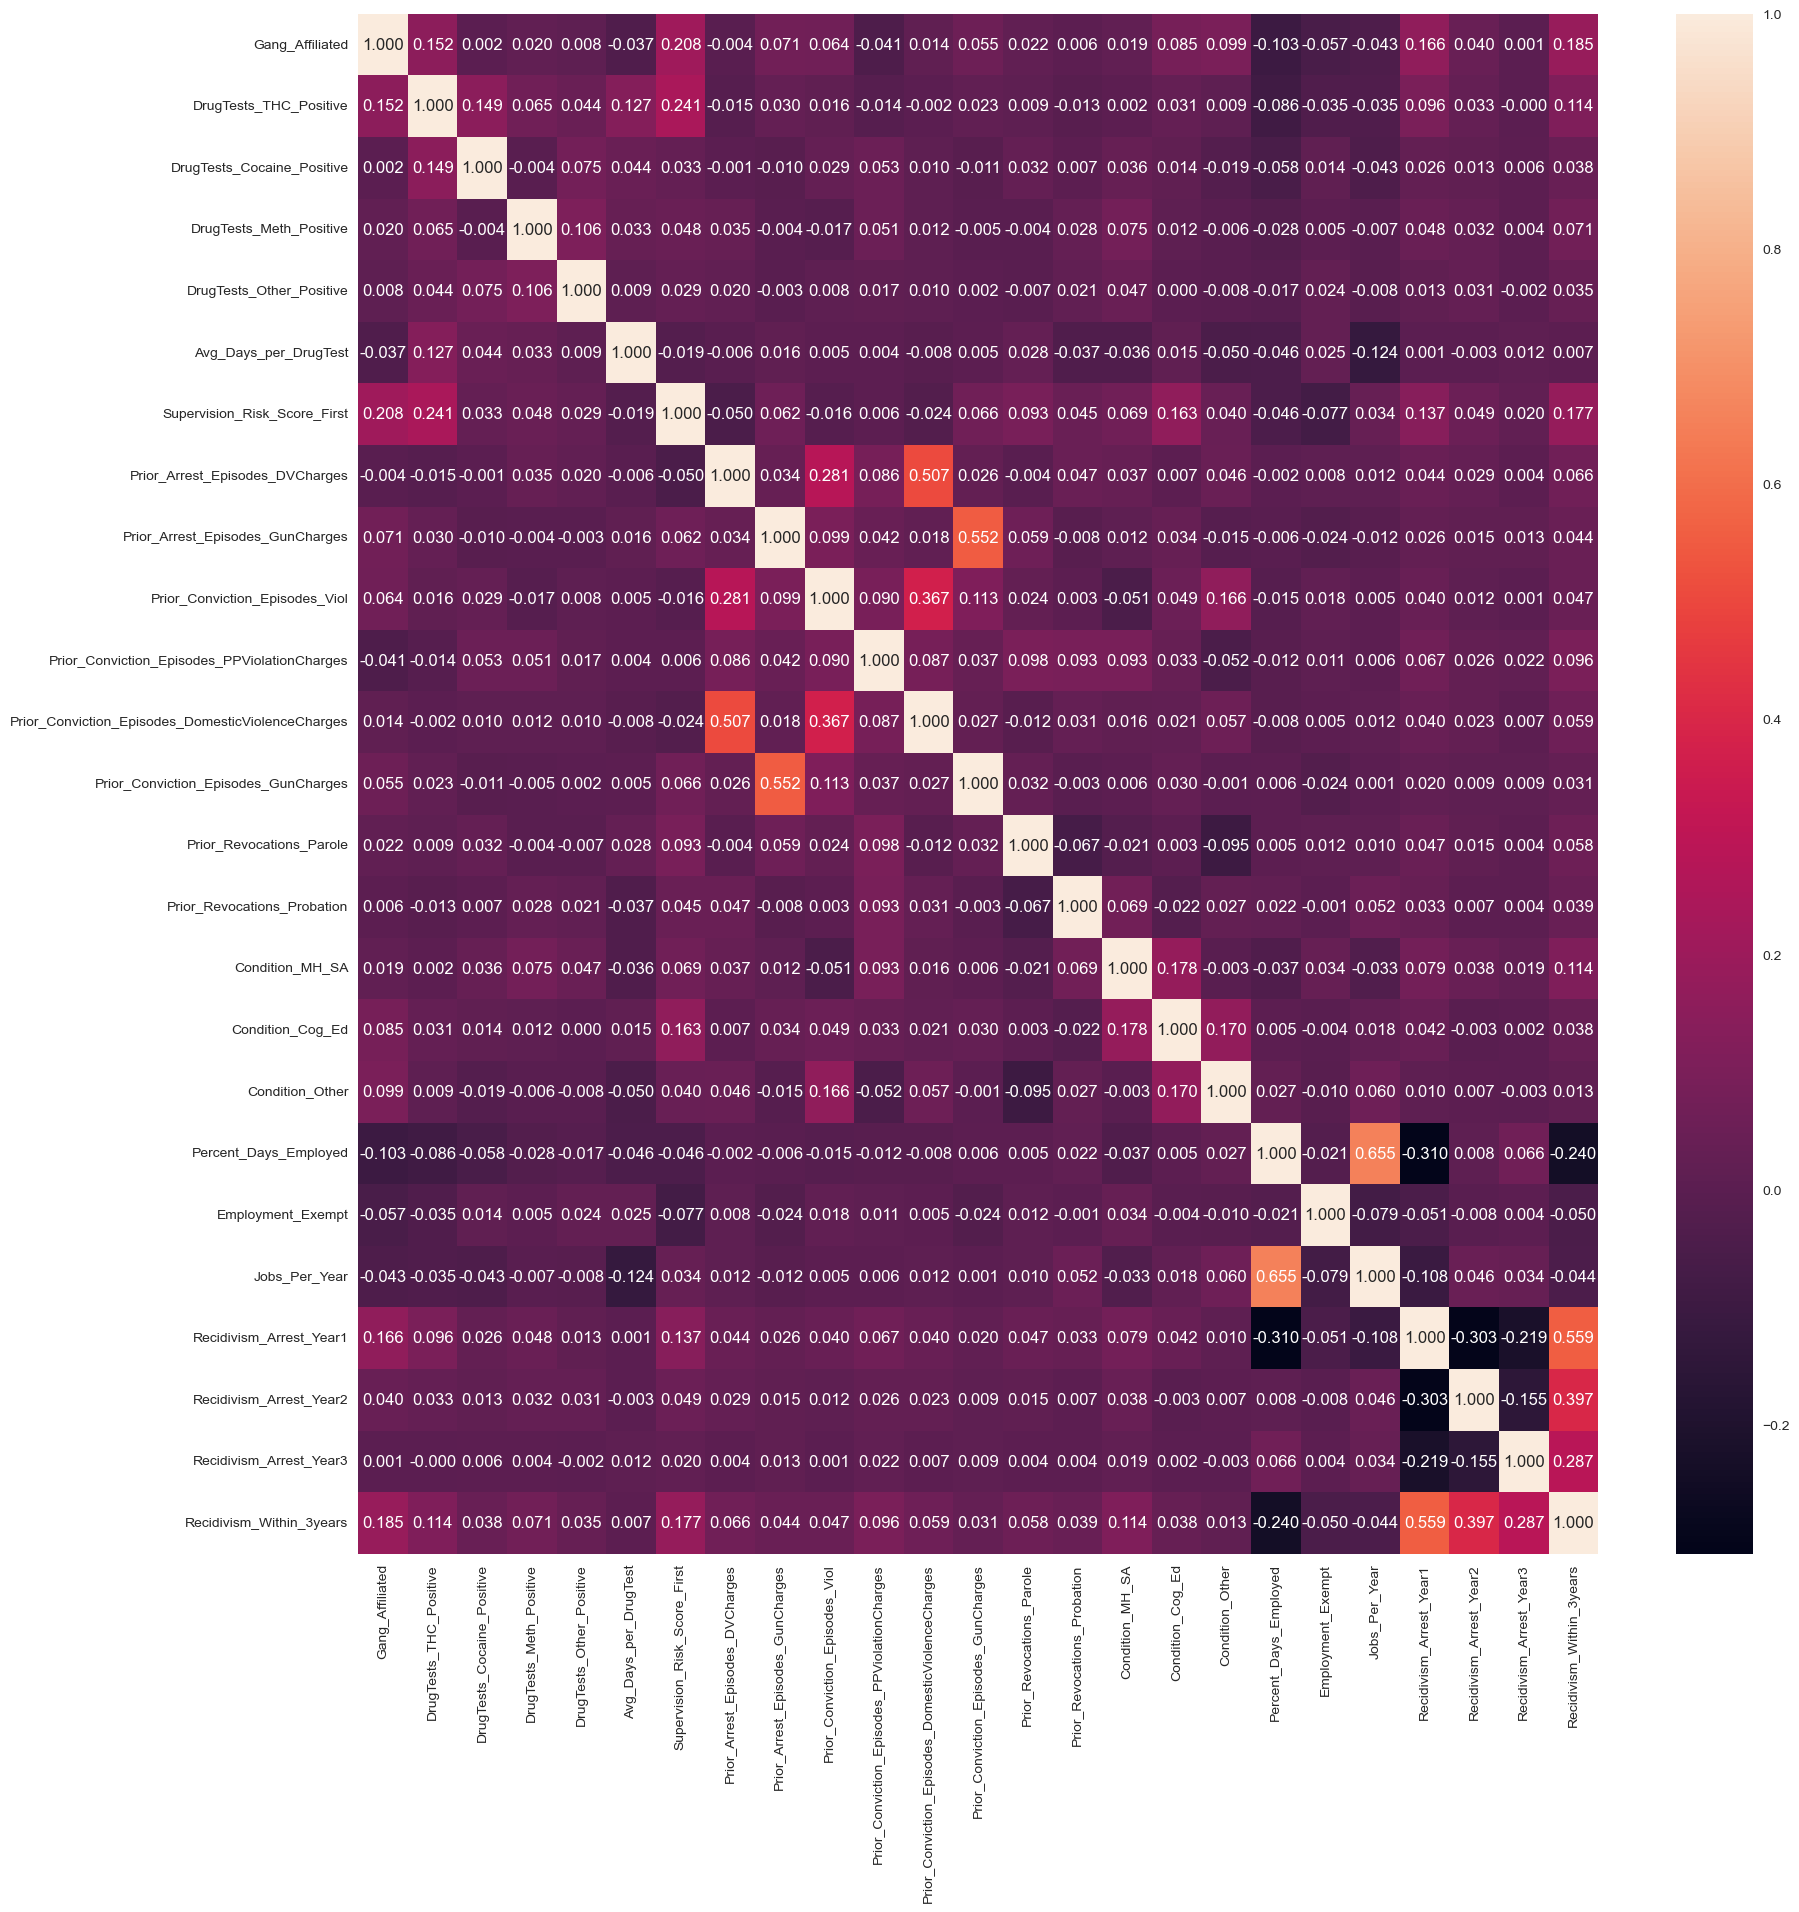

In [14]:
plt.figure(figsize=(20,20))
# Correlation heatmap
corr = df[["Gang_Affiliated",'DrugTests_THC_Positive','DrugTests_Cocaine_Positive','DrugTests_Meth_Positive','DrugTests_Other_Positive',"Avg_Days_per_DrugTest","Supervision_Risk_Score_First","Prior_Arrest_Episodes_DVCharges","Prior_Arrest_Episodes_GunCharges",
          "Prior_Conviction_Episodes_Viol","Prior_Conviction_Episodes_PPViolationCharges","Prior_Conviction_Episodes_DomesticViolenceCharges",
          "Prior_Conviction_Episodes_GunCharges","Prior_Revocations_Parole","Prior_Revocations_Probation","Condition_MH_SA",
           "Condition_Cog_Ed","Condition_Other","Percent_Days_Employed","Employment_Exempt","Jobs_Per_Year",
           "Recidivism_Arrest_Year1","Recidivism_Arrest_Year2","Recidivism_Arrest_Year3","Recidivism_Within_3years"]].corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns, fmt = ".3f")

In [15]:
plt.rcParams["figure.figsize"] = [12,8]

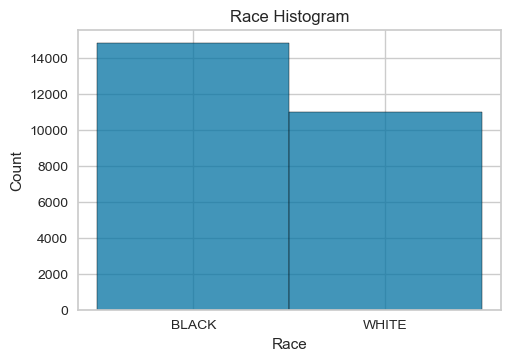

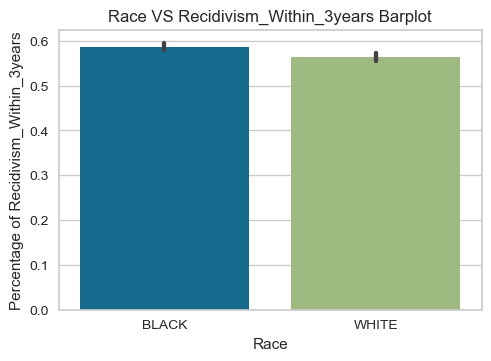

In [16]:
fig = plt.figure()

ax1 = plt.subplot(221)
# Create histogram
sns.histplot(df["Race"], ax = ax1)
# Add title
plt.title("Race Histogram")
# Show plot
plt.show()


ax2 = plt.subplot(222)
sns.barplot(x="Race", y="Recidivism_Within_3years", data=df, ax = ax2)
plt.xlabel("Race")
plt.ylabel("Percentage of Recidivism_Within_3years")
plt.title("Race VS Recidivism_Within_3years Barplot")
plt.show()

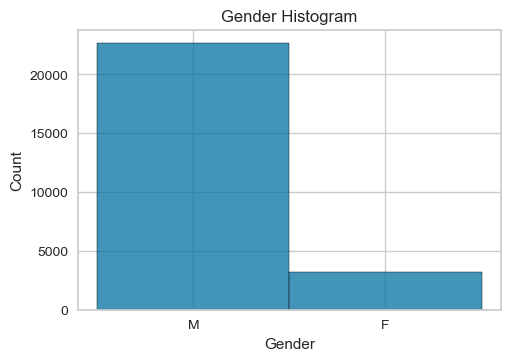

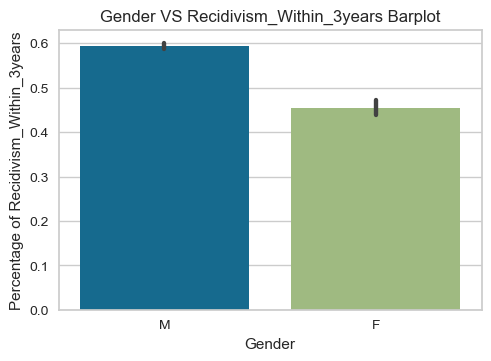

In [17]:
fig = plt.figure()

ax1 = plt.subplot(221)
# Create histogram
sns.histplot(df["Gender"], ax = ax1)

# Add title
plt.title("Gender Histogram")

# Show plot
plt.show()


ax2 = plt.subplot(222)
# Create bar chart using Seaborn
sns.barplot(x="Gender", y="Recidivism_Within_3years", data=df, ax = ax2)

# Add labels and title
plt.xlabel("Gender")
plt.ylabel("Percentage of Recidivism_Within_3years")
plt.title("Gender VS Recidivism_Within_3years Barplot")

# Show plot
plt.show()

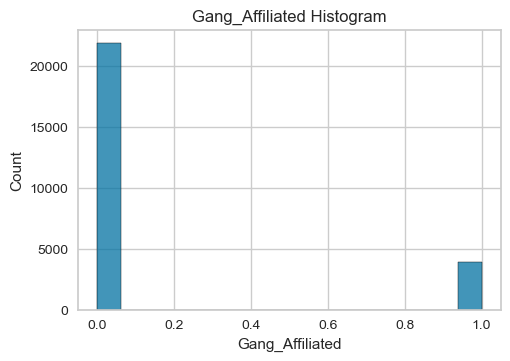

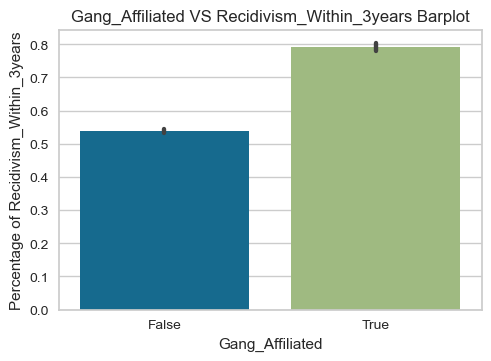

In [18]:
fig = plt.figure()

ax1 = plt.subplot(221)
# Create histogram
sns.histplot(df["Gang_Affiliated"], ax = ax1)

# Add title
plt.title("Gang_Affiliated Histogram")

# Show plot
plt.show()


ax2 = plt.subplot(222)
# Create bar chart using Seaborn
sns.barplot(x="Gang_Affiliated", y="Recidivism_Within_3years", data=df, ax = ax2)

# Add labels and title
plt.xlabel("Gang_Affiliated")
plt.ylabel("Percentage of Recidivism_Within_3years")
plt.title("Gang_Affiliated VS Recidivism_Within_3years Barplot")

# Show plot
plt.show()

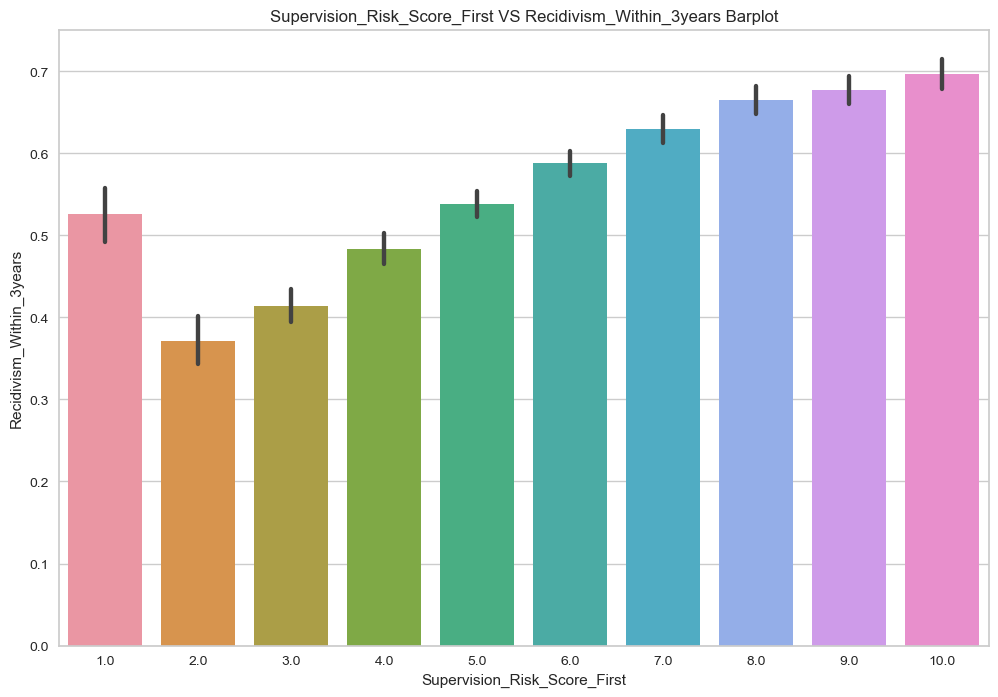

In [19]:
# Create box plot
sns.barplot(x="Supervision_Risk_Score_First", y="Recidivism_Within_3years", data=df)

# Add title and labels
plt.title("Supervision_Risk_Score_First VS Recidivism_Within_3years Barplot")
plt.xlabel("Supervision_Risk_Score_First")
plt.ylabel("Recidivism_Within_3years")

# Show plot
plt.show()

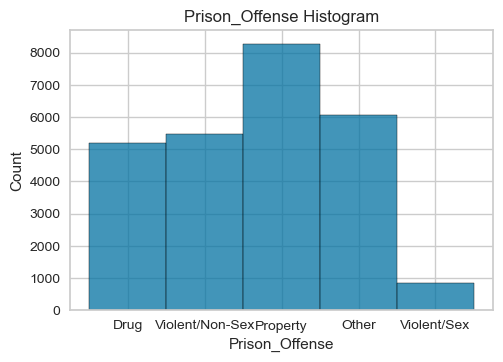

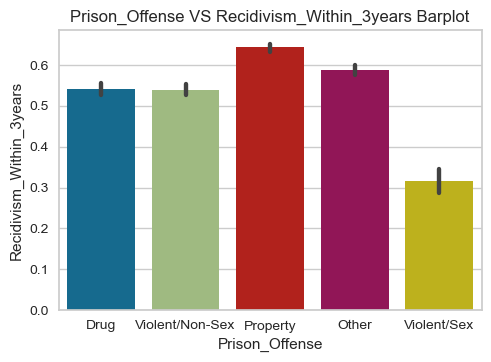

In [20]:
fig = plt.figure()

ax1 = plt.subplot(221)
# Create histogram
sns.histplot(df["Prison_Offense"], ax = ax1)

# Add title
plt.title("Prison_Offense Histogram")

# Show plot
plt.show()


ax2 = plt.subplot(222)
# Create box plot
sns.barplot(x="Prison_Offense", y="Recidivism_Within_3years", data=df, ax = ax2)

# Add title and labels
plt.title("Prison_Offense VS Recidivism_Within_3years Barplot")
plt.xlabel("Prison_Offense")
plt.ylabel("Recidivism_Within_3years")

# Show plot
plt.show()

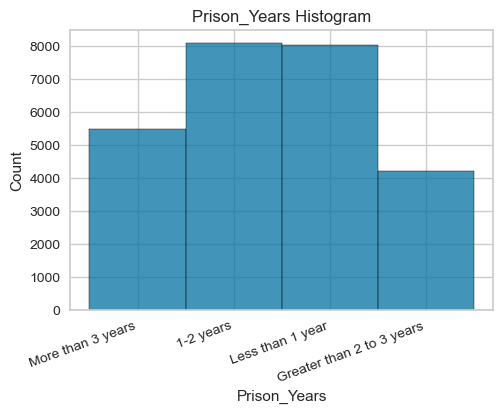

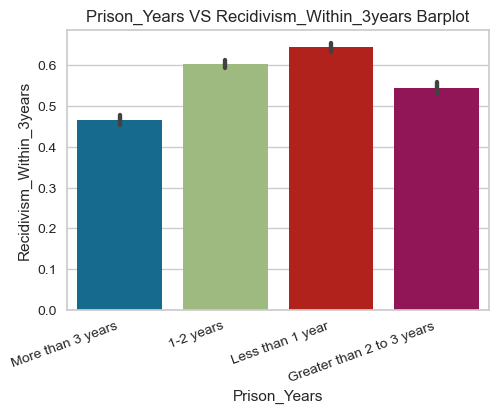

In [21]:
fig = plt.figure()

ax1 = plt.subplot(221)
# Create histogram
sns.histplot(df["Prison_Years"], ax = ax1)

# Add title
plt.title("Prison_Years Histogram")
plt.xticks(rotation=20, ha='right')

# Show plot
plt.show()


ax2 = plt.subplot(222)
# Create box plot
sns.barplot(x="Prison_Years", y="Recidivism_Within_3years", data=df, ax = ax2)

# Add title and labels
plt.title("Prison_Years VS Recidivism_Within_3years Barplot")
plt.xlabel("Prison_Years")
plt.ylabel("Recidivism_Within_3years")
plt.xticks(rotation=20, ha='right')

# Show plot
plt.show()

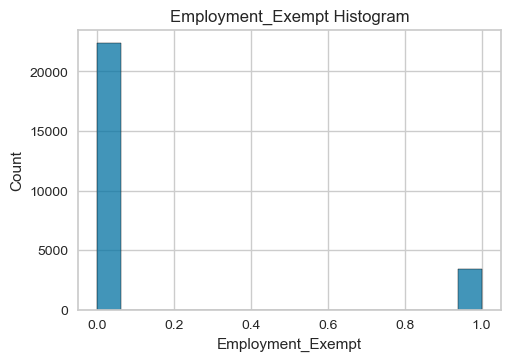

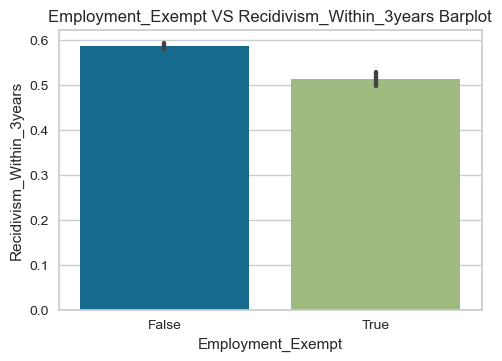

In [22]:
fig = plt.figure()

ax1 = plt.subplot(221)
# Create histogram
sns.histplot(df["Employment_Exempt"], ax = ax1)

# Add title
plt.title("Employment_Exempt Histogram")

# Show plot
plt.show()


ax2 = plt.subplot(222)
# Create box plot
sns.barplot(x="Employment_Exempt", y="Recidivism_Within_3years", data=df, ax = ax2)

# Add title and labels
plt.title("Employment_Exempt VS Recidivism_Within_3years Barplot")
plt.xlabel("Employment_Exempt")
plt.ylabel("Recidivism_Within_3years")

# Show plot
plt.show()

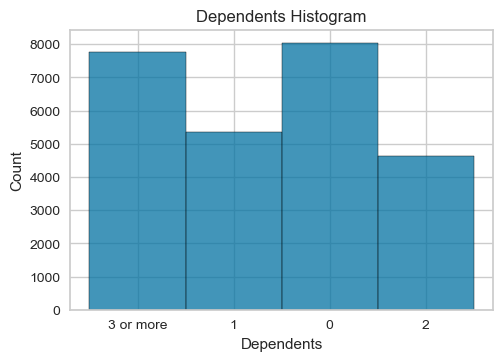

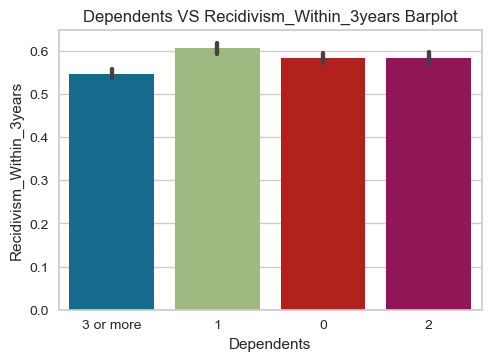

In [23]:
fig = plt.figure()

ax1 = plt.subplot(221)
# Create histogram
sns.histplot(df["Dependents"], ax = ax1)

# Add title
plt.title("Dependents Histogram")

# Show plot
plt.show()


ax2 = plt.subplot(222)
# Create box plot
sns.barplot(x="Dependents", y="Recidivism_Within_3years", data=df, ax = ax2)

# Add title and labels
plt.title("Dependents VS Recidivism_Within_3years Barplot")
plt.xlabel("Dependents")
plt.ylabel("Recidivism_Within_3years")

# Show plot
plt.show()

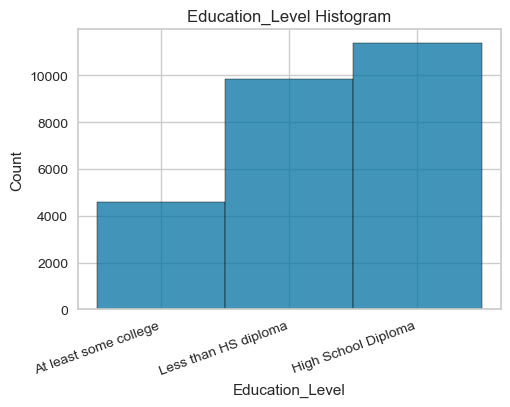

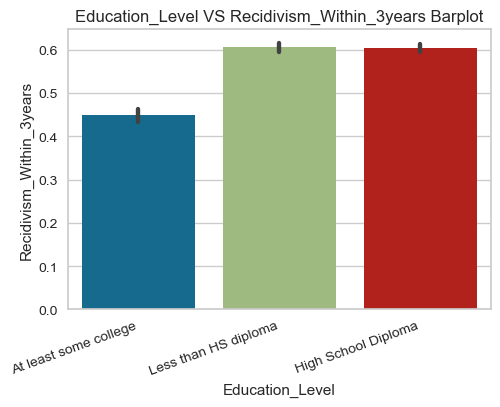

In [59]:
fig = plt.figure()

ax1 = plt.subplot(221)
# Create histogram
sns.histplot(df["Education_Level"], ax = ax1)

# Add title
plt.title("Education_Level Histogram")
plt.xticks(rotation=20, ha='right')
# Show plot
plt.show()


ax2 = plt.subplot(222)
# Create box plot
sns.barplot(x="Education_Level", y="Recidivism_Within_3years", data=df, ax = ax2)

# Add title and labels
plt.title("Education_Level VS Recidivism_Within_3years Barplot")
plt.xlabel("Education_Level")
plt.ylabel("Recidivism_Within_3years")
plt.xticks(rotation=20, ha='right')
# Show plot
plt.show()

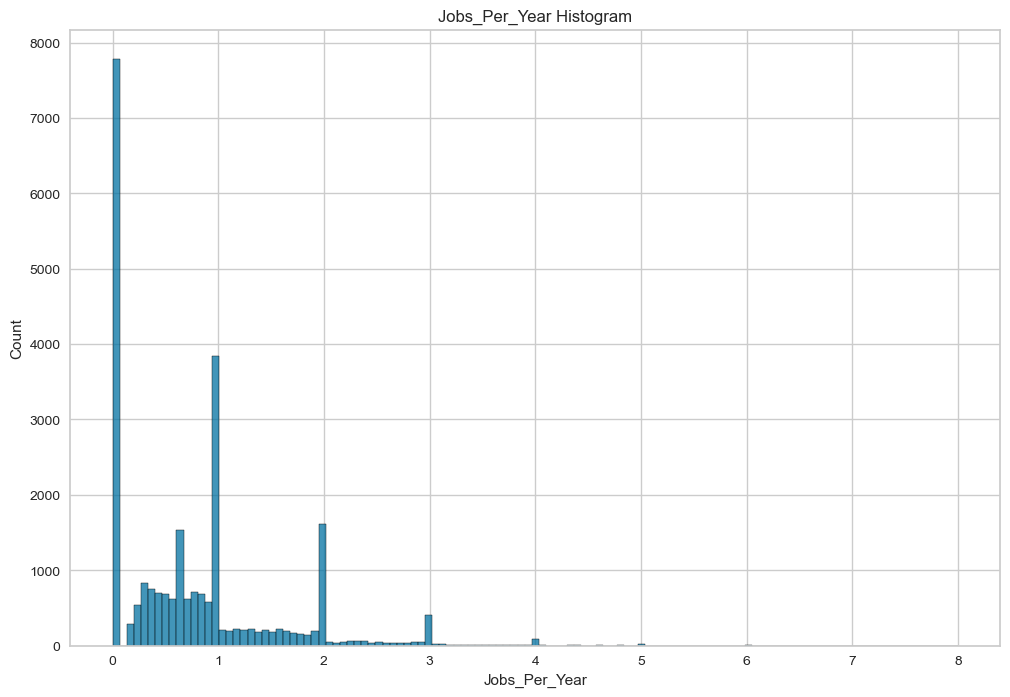

In [25]:
# Create histogram
sns.histplot(df["Jobs_Per_Year"])

# Add title
plt.title("Jobs_Per_Year Histogram")

# Show plot
plt.show()

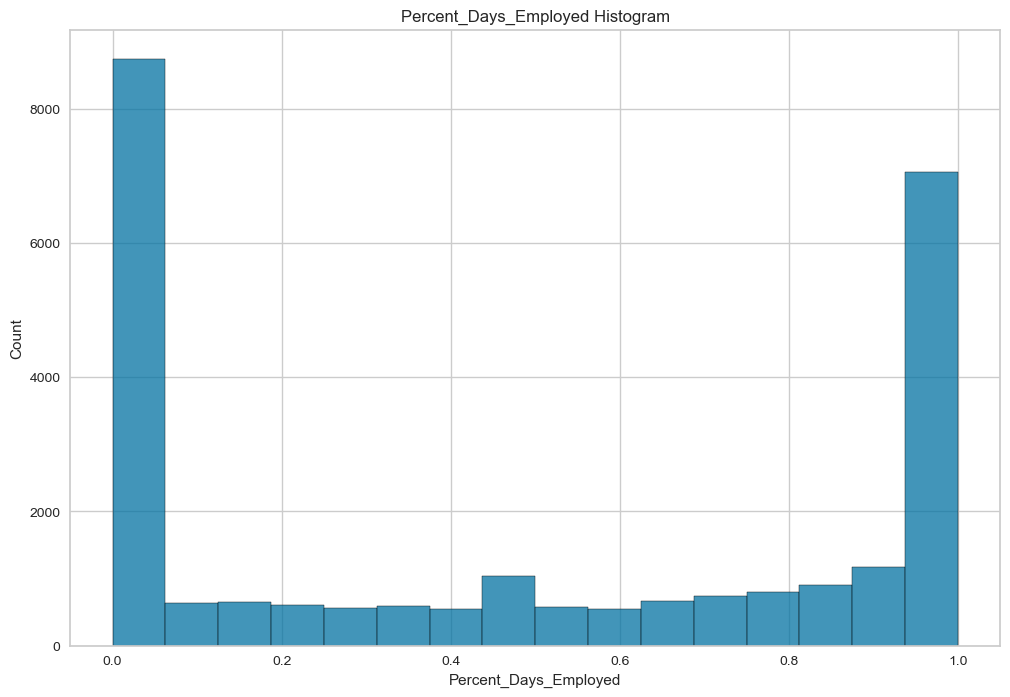

In [26]:
# Create histogram
sns.histplot(df["Percent_Days_Employed"])

# Add title
plt.title("Percent_Days_Employed Histogram")

# Show plot
plt.show()

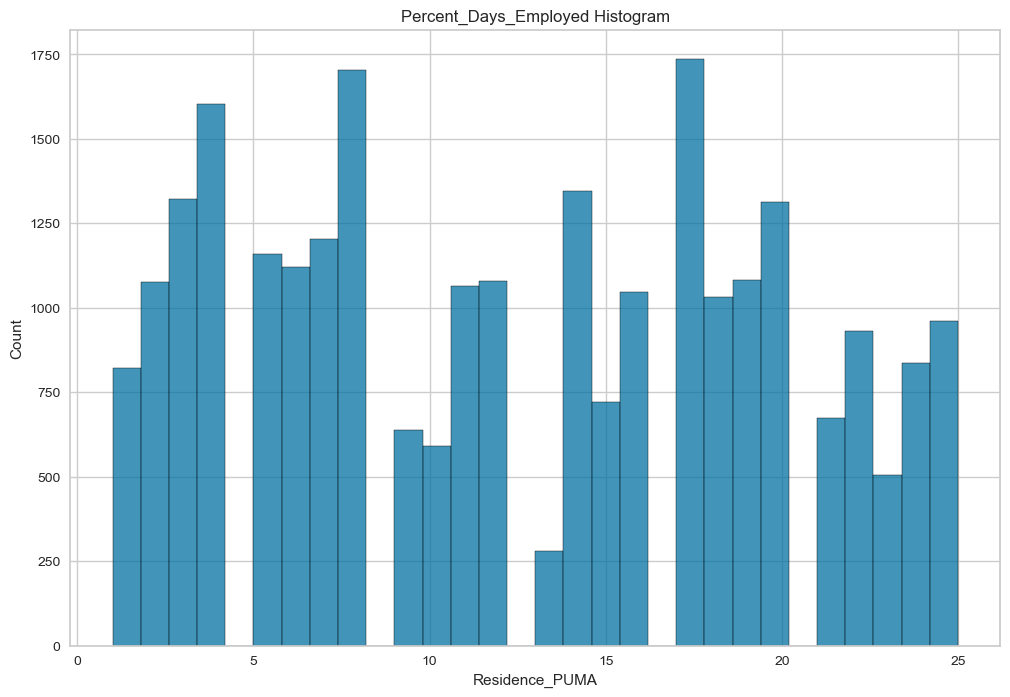

In [106]:
# Create histogram
sns.histplot(df["Residence_PUMA"])

# Add title
plt.title("Residence_PUMA Histogram")

# Show plot
plt.show()

# Data Analysis & Machine Learning 

## Data Preprocessing

In [27]:
# all columns
df.columns

Index(['Gender', 'Race', 'Age_at_Release', 'Residence_PUMA', 'Gang_Affiliated',
       'Supervision_Risk_Score_First', 'Supervision_Level_First',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Con

In [28]:
# numerical columns
df.describe().columns

Index(['Residence_PUMA', 'Supervision_Risk_Score_First',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year'],
      dtype='object')

In [29]:
# Using one hot encoding to get matrix
data = pd.get_dummies(df, columns=['Gender', 'Race', 'Age_at_Release', 'Gang_Affiliated',
       'Supervision_Level_First',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Condition_Other', 'Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes',
       'Employment_Exempt', 'Recidivism_Within_3years',
       'Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2',
       'Recidivism_Arrest_Year3'], drop_first=True)

# Standardize numerical variable
numerical = ['Residence_PUMA', 'Supervision_Risk_Score_First',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year']
data[numerical] = StandardScaler().fit_transform(df.loc[:, numerical])


# X and y vriable split
X = data.iloc[:, :-4]
y = data.iloc[:, -4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## This report will use recall to measure accuracy
Recall — What percent of the positive cases did you catch?

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

Recall:- Fraction of positives that were correctly identified.

Recall = TP/(TP+FN)

## K-means & PCA

In [30]:
numerical = ['Residence_PUMA', 'Supervision_Risk_Score_First',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year']
# Standardize the data
standard = preprocessing.scale(df[numerical].values)
print(standard)

[[ 0.51000926 -1.30570037  5.08425134 ... -0.16354061  0.01507581
  -0.39622842]
 [ 0.51000926 -0.03420512 -0.47387167 ... -0.16354061 -0.135284
   1.54114864]
 [ 1.63146208  0.38962663  0.08547674 ... -0.16354061 -1.14491004
  -0.95484455]
 ...
 [ 0.36982766 -0.45803687 -0.28332534 ... -0.16354061  0.54353528
   0.16102022]
 [ 0.36982766 -0.45803687 -0.25752599 ... -0.16354061 -1.14491004
  -0.95484455]
 [-0.05071714 -0.45803687  0.06554594 ... -0.16354061 -0.84942037
  -0.45721272]]


In [31]:
# Do PCA to reduce dimensional to 2
PCA_x = PCA(n_components = 2).fit_transform(standard)

In [32]:
PCA_r = pd.DataFrame(PCA_x)
PCA_r["Recidivism_Within_3years"] = df["Recidivism_Within_3years"]

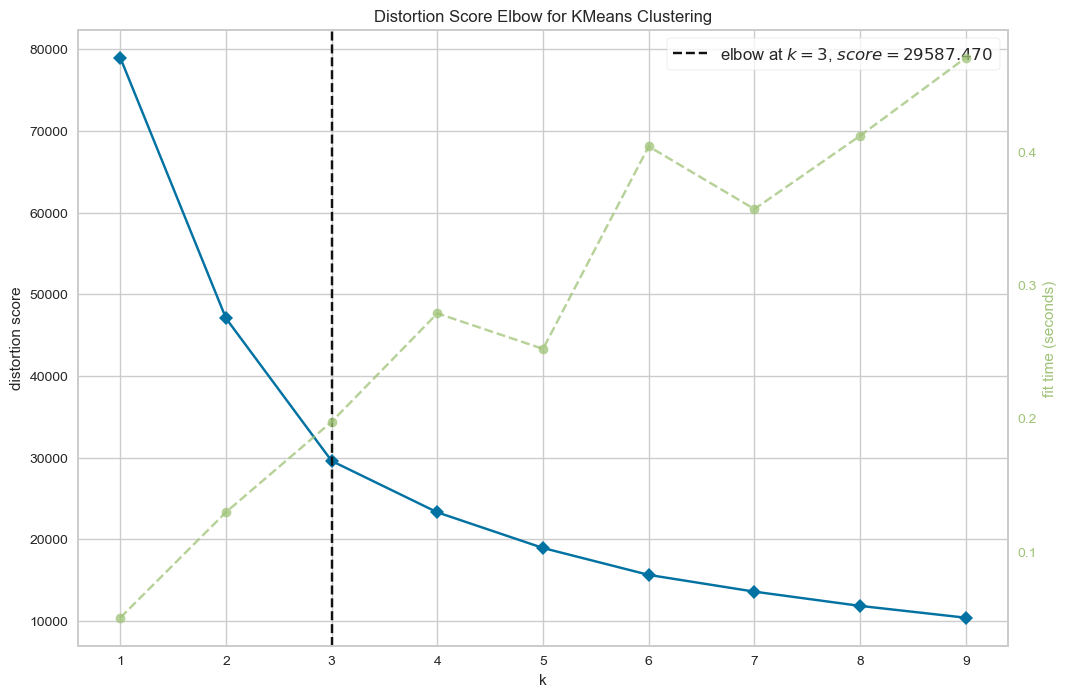

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
# Elbow method to get the optimal value of K for K-means
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(PCA_x)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [34]:
# Do the K-means
clf = KMeans(n_clusters=3, init = "k-means++", max_iter = 100, random_state=0).fit(PCA_x)
clf.cluster_centers_;

In [35]:
df3 = pd.DataFrame(PCA_x)
df3["k_means_labels"] = clf.labels_
df3['Recidivism_Within_3years'] = PCA_r["Recidivism_Within_3years"]
df_1 = df3[df3['k_means_labels'] == 0]
df_2 = df3[df3['k_means_labels'] == 1]
df3

,0,1,k_means_labels,Recidivism_Within_3years
0,-0.975653,-0.460126,0,False
1,1.211507,-0.107350,1,True
2,-1.938656,1.603559,2,True
3,1.045607,-0.066529,1,False
4,0.030322,-0.756622,0,True
...,...,...,...,...
25830,-0.547910,-0.757206,0,True
25831,0.721907,-0.701222,1,True
25832,0.747941,-0.534810,1,True
25833,-1.086257,-1.177936,0,False


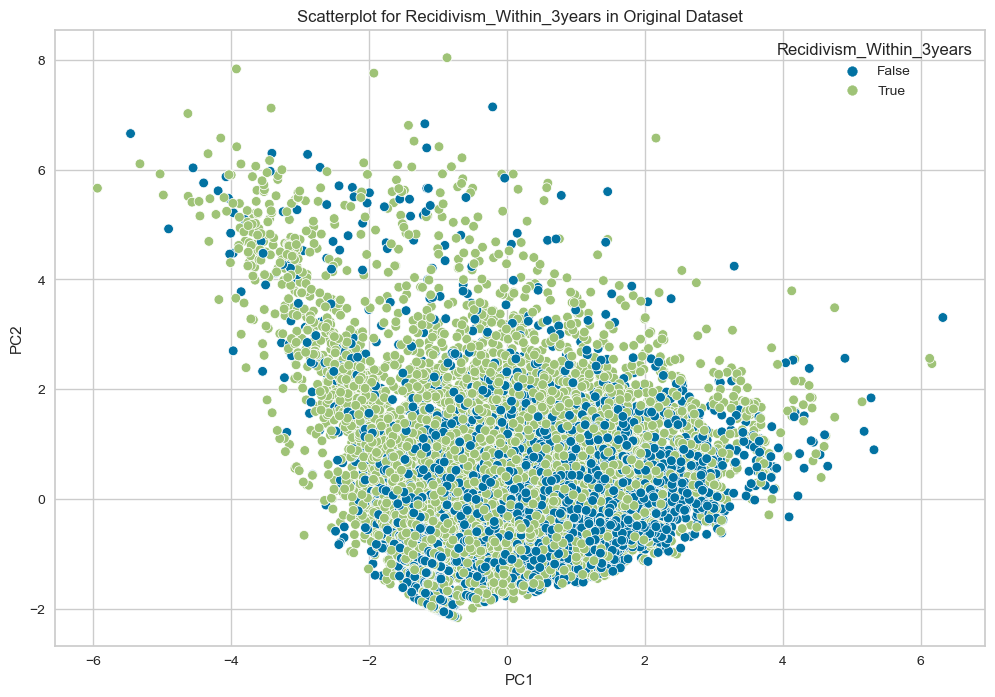

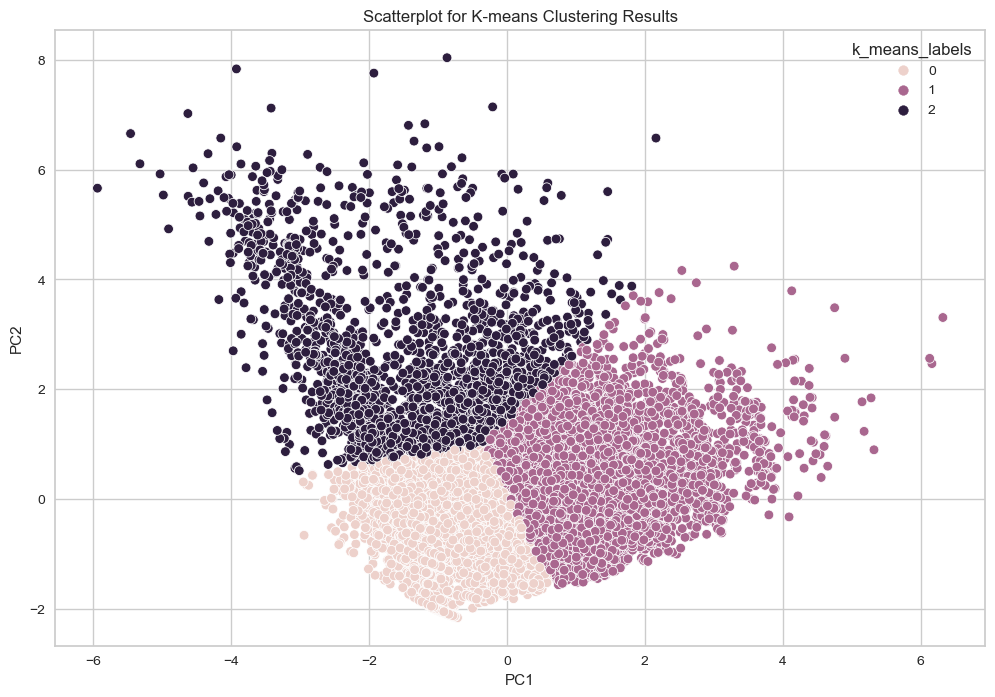

In [36]:
# Visualize the K-means results
sns.scatterplot(data = df3, x=0, y=1, hue='Recidivism_Within_3years')
plt.title("Scatterplot for Recidivism_Within_3years in Original Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


sns.scatterplot(data = df3, x=0, y=1, hue = "k_means_labels")
plt.title("Scatterplot for K-means Clustering Results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [37]:
X_clustered = pd.DataFrame(standard, index = df[numerical].index, columns = df[numerical].columns)
X_clustered["cluster"] = clf.labels_

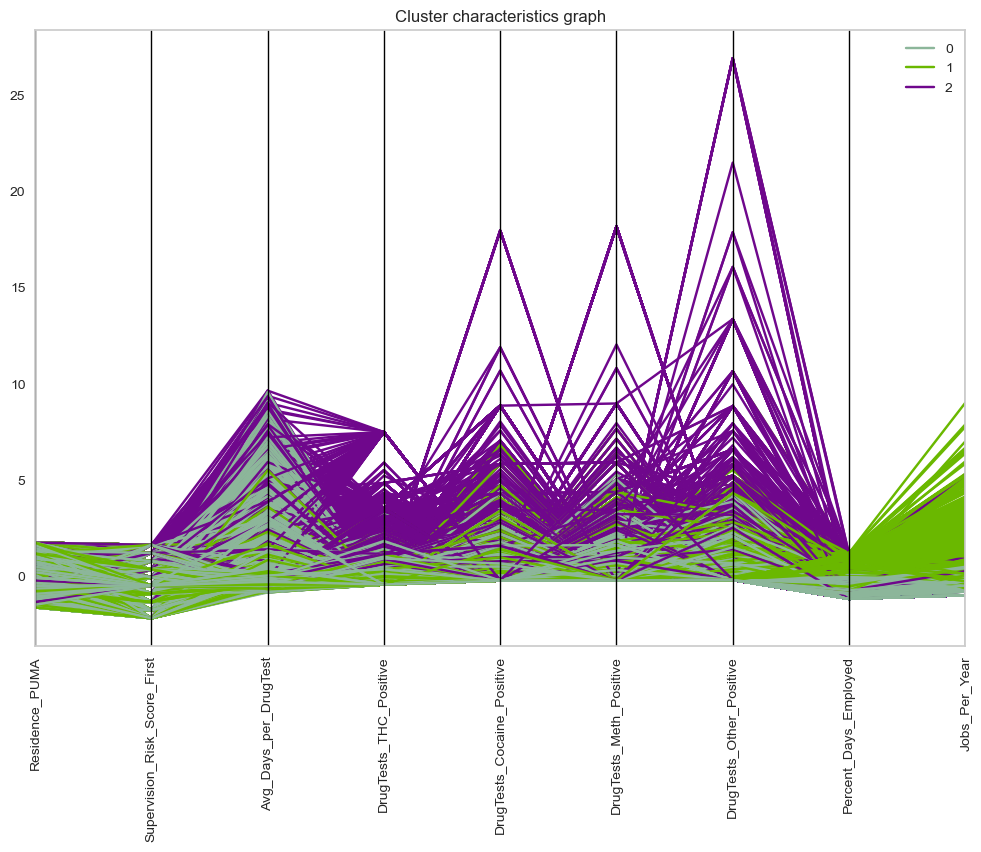

In [108]:
# See the characteristics of each cluster
pd.plotting.parallel_coordinates(X_clustered,"cluster")
plt.xticks(rotation=90)
plt.title("Cluster characteristics graph")
plt.show()

## Logistic Regression

In [39]:
# Run logistic regression one time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
clf = LogisticRegression(penalty='l2', solver='newton-cg')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('recall = TP / (TP+FN) = ', recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.58      0.62      2186
           1       0.72      0.79      0.75      2981

    accuracy                           0.70      5167
   macro avg       0.70      0.69      0.69      5167
weighted avg       0.70      0.70      0.70      5167

recall = TP / (TP+FN) =  0.7913451861791345


Text(0.5, 1.0, 'ROC Curve')

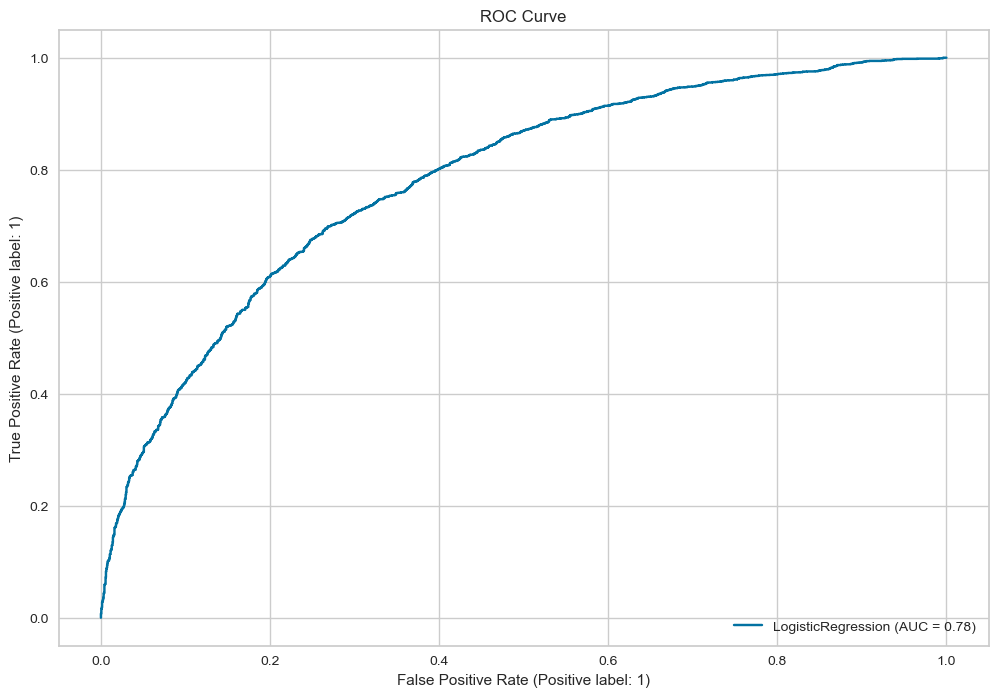

In [103]:
# plot ROC curve
plot_roc_curve(clf, X_test, y_test)
plt.title("ROC Curve")

Text(0.5, 1.0, 'Precision Recall Curve')

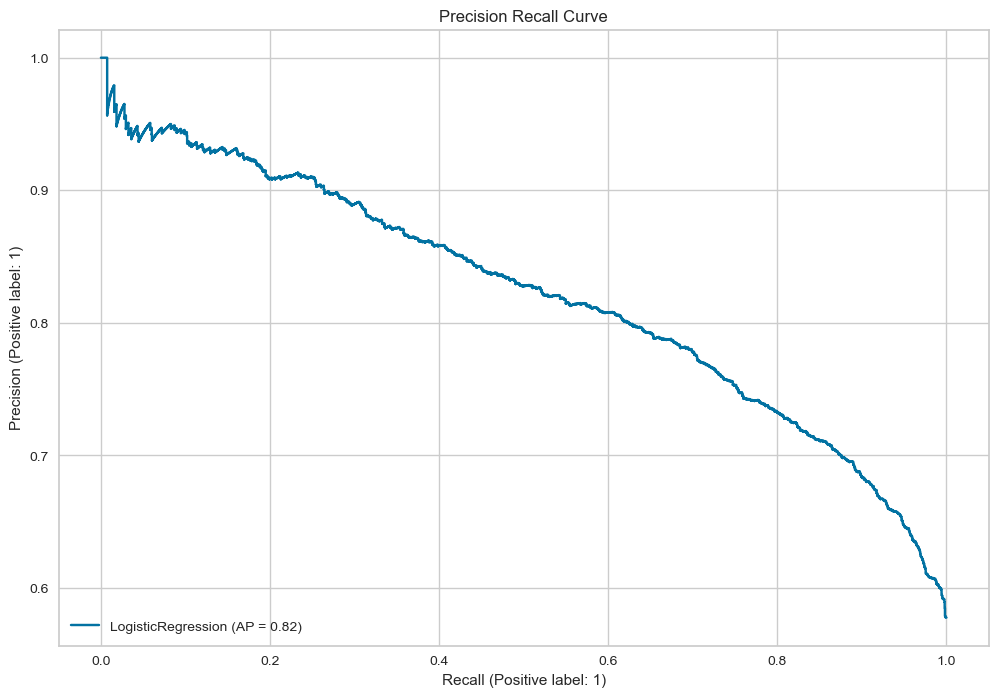

In [102]:
# plot precision_recall_curve
plot_precision_recall_curve(clf, X_test, y_test)
plt.title("Precision Recall Curve")

Confusion Matrix


Text(0.5, 1.0, 'Confusion Matrix')

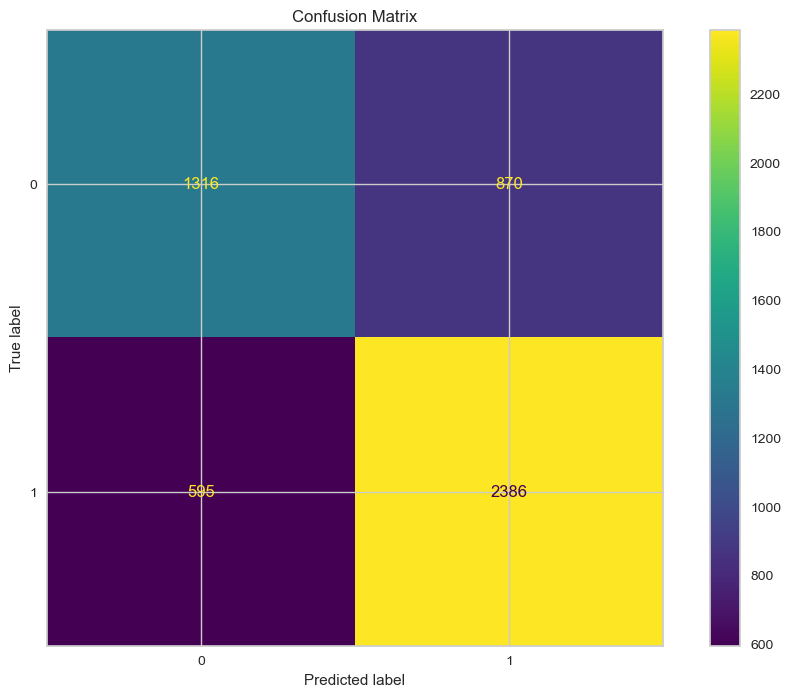

In [101]:
print('Confusion Matrix')
plot_confusion_matrix(clf, X_test, y_test)
plt.title("Confusion Matrix")

In [43]:
# Run Logistic Regression 100 times to get histogram of recall
LR_recall_100 = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    clf = LogisticRegression(penalty='l2', solver='newton-cg')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    LR_recall_100.append(recall_score(y_test, y_pred))

[Text(0.5, 1.0, 'Histogram of Recall using Logistic Regression')]

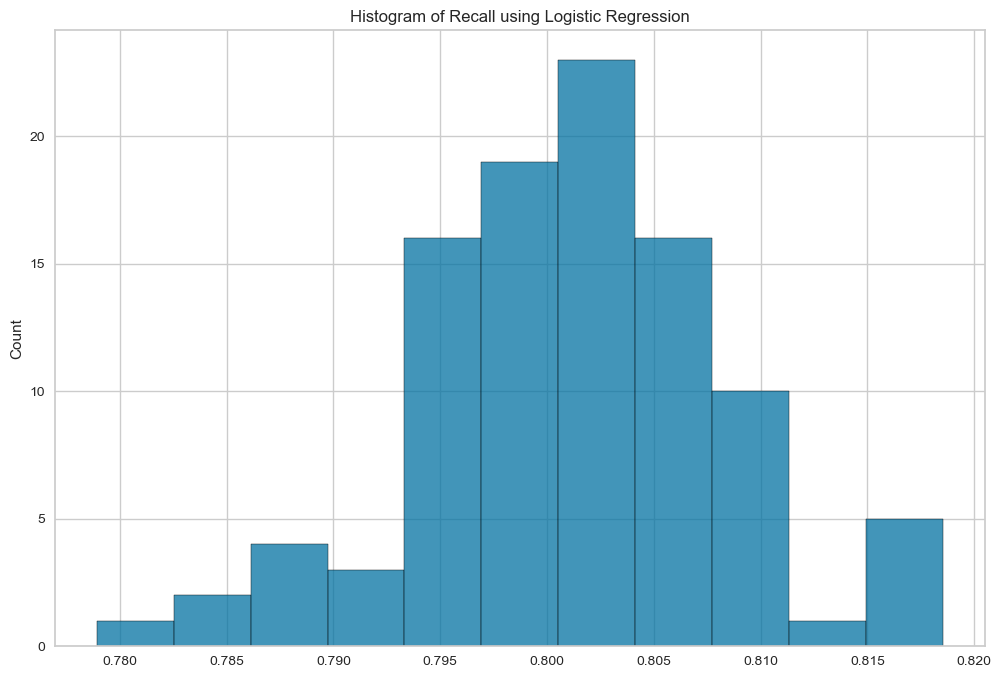

In [44]:
# Plot Histogram of Recall
sns.histplot(LR_recall_100).set(title='Histogram of Recall using Logistic Regression')

## Random Forest

In [109]:
# Use grid search to find best random forest parameters
rf = RandomForestClassifier()
n_estimators = [100, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 50]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  14.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  15.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  11.7s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  11.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  14.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=50, max_features=

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=42, verbose=2)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50}
Recall: 0.8473666554847367


Text(0.5, 1.0, 'Confusion Matrix')

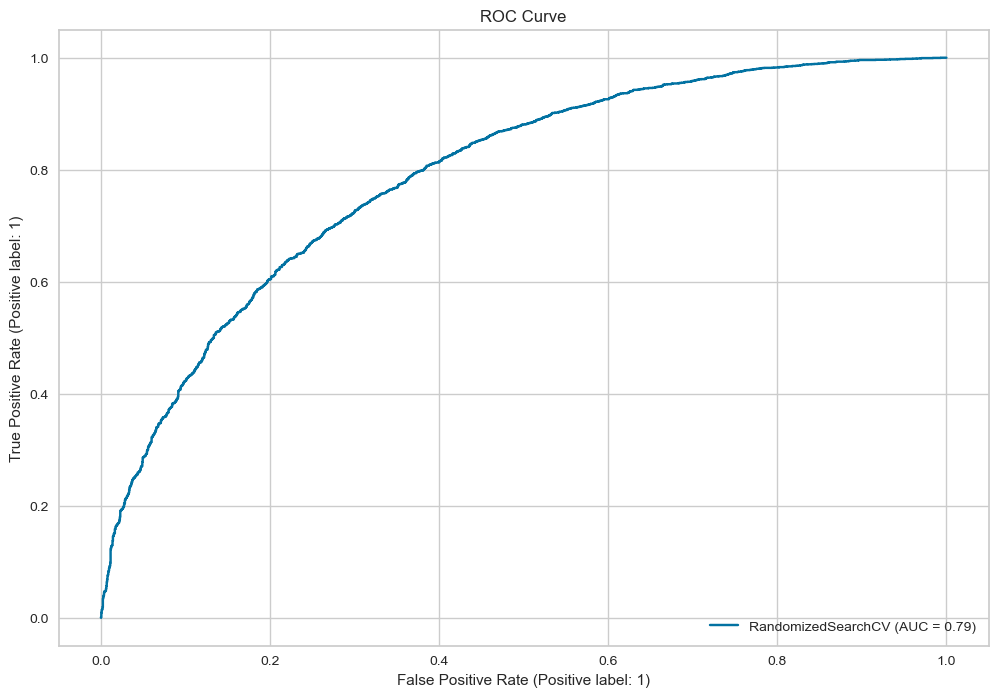

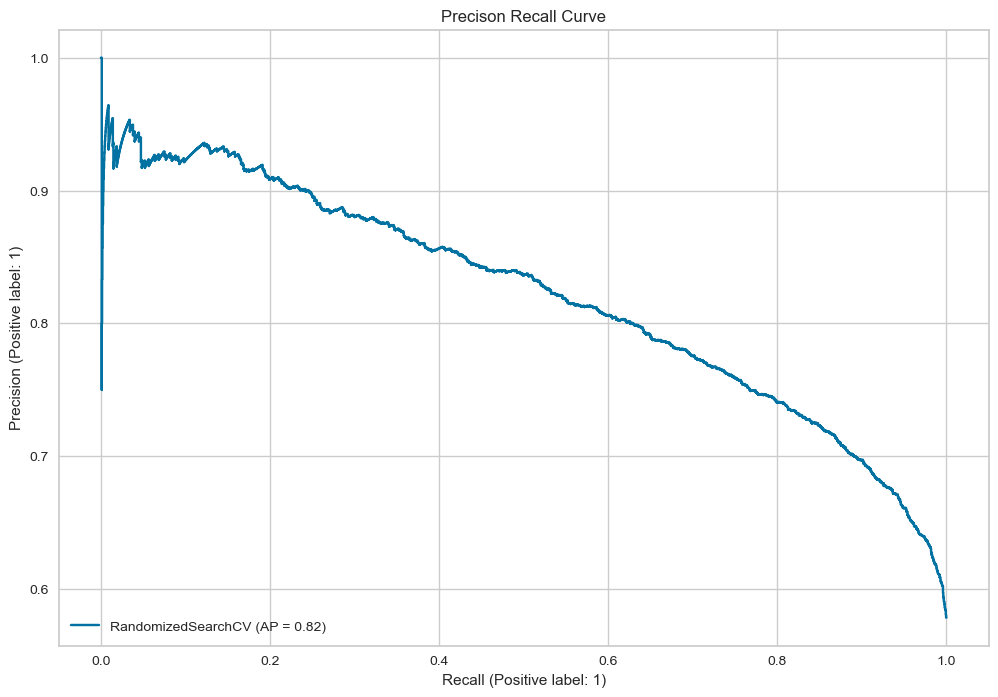

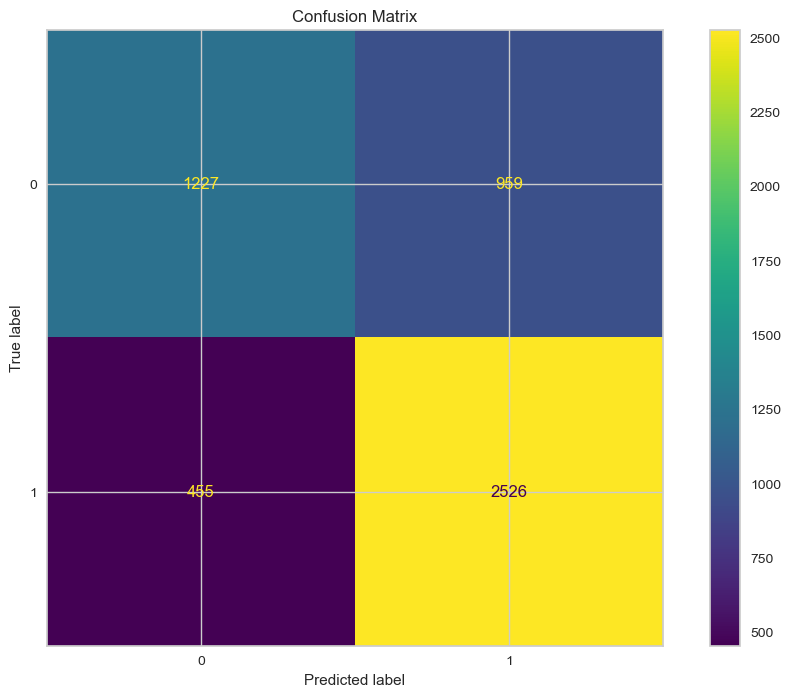

In [110]:
# Output best random forest parameter, ROC curve, precision_recall_curve and confusion matrix
print('Best hyperparameters:', rf_random.best_params_)
y_pred = rf_random.predict(X_test)
print("Recall:", recall_score(y_test, y_pred))
plot_roc_curve(rf_random, X_test, y_test)
plt.title("ROC Curve")
plot_precision_recall_curve(rf_random, X_test, y_test)
plt.title("Precison Recall Curve")
plot_confusion_matrix(rf_random, X_test, y_test)
plt.title("Confusion Matrix")

In [111]:
rf_hp = pd.DataFrame(rf_random.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [112]:
# Show the feature importance for random forest fit
rf_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
Percent_Days_Employed,0.096615
Jobs_Per_Year,0.071783
Avg_Days_per_DrugTest,0.051867
Supervision_Risk_Score_First,0.044373
Residence_PUMA,0.041213
...,...
Program_Attendances_2,0.001480
Program_Attendances_4,0.001416
Program_Attendances_3,0.001070
Program_Attendances_8,0.000889


Text(0, 0.5, 'Feature')

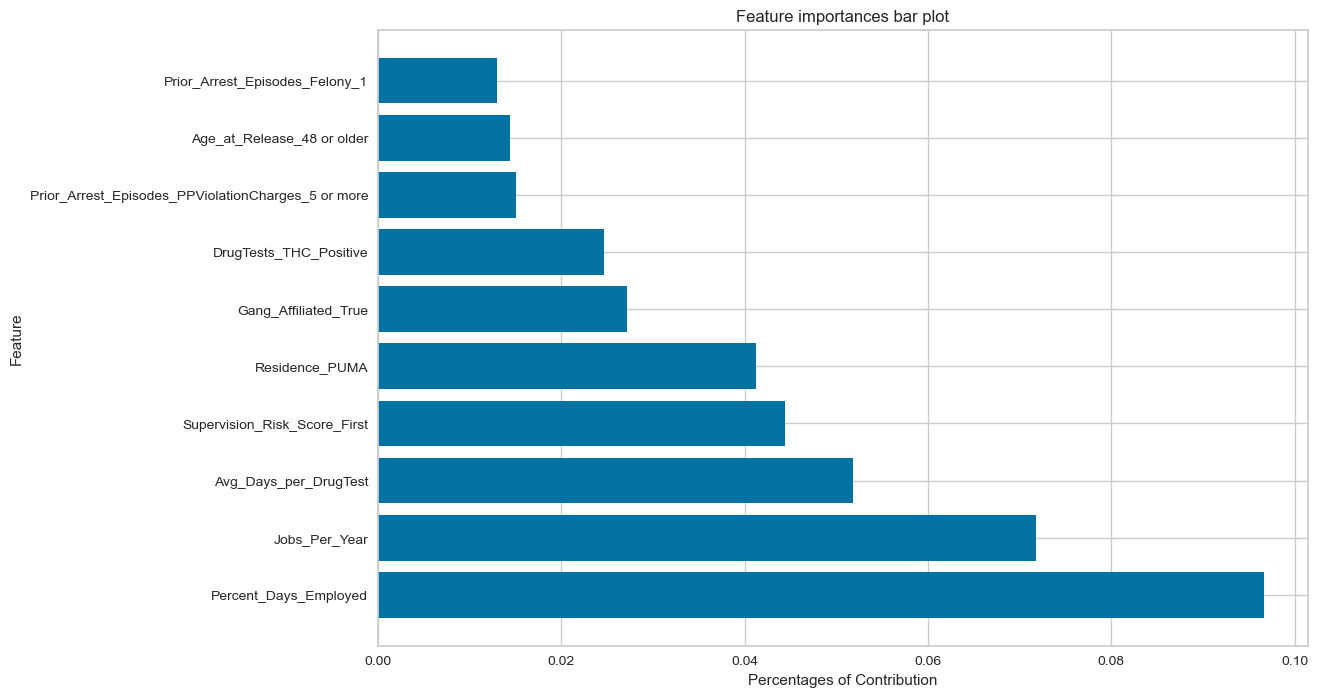

In [113]:
a = rf_hp.sort_values(by = "feature_importances", ascending = False)
plt.barh(a[:10].index, a[:10].feature_importances.values)
plt.title("Feature importances bar plot")
plt.xlabel("Percentages of Contribution")
plt.ylabel("Feature")

In [115]:
# run best random forest model 100 times to get histogram of recall
RF_recall_100 = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    rf = RandomForestClassifier(n_estimators = 500, min_samples_split=5, min_samples_leaf=2, max_features='auto', max_depth=50, random_state = 42)
    rf.fit(X_train, y_train);
    y_pred = rf.predict(X_test)
    RF_recall_100.append(recall_score(y_test, y_pred))

[Text(0.5, 1.0, 'Histogram of Recall using Random Forest')]

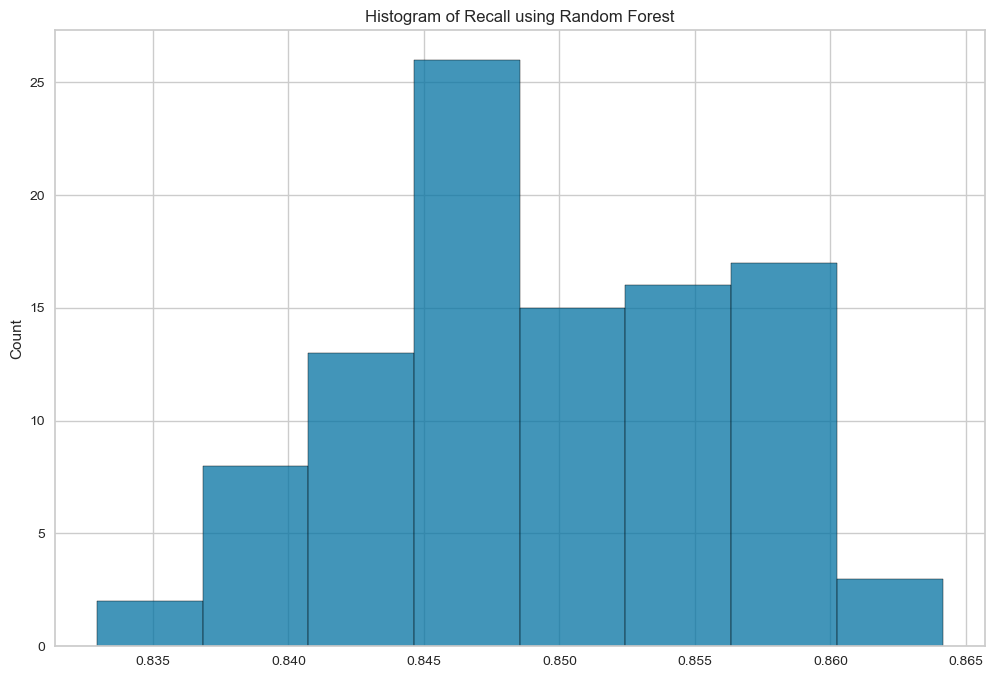

In [116]:
sns.histplot(RF_recall_100).set(title='Histogram of Recall using Random Forest')

## XGBoost

In [53]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier()

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 4, 5, 10],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 300, 1000]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print('Best parameters:', grid_search.best_params_)

# Make predictions on the test set with the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=  48.0s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=  20.7s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=300; total time= 1.0min
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1000; total time= 3.4min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=  52.9s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=300; total time= 2.6min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  15.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  46.9s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time= 2.6min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=  21.8s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=300; total time= 1.1min
[CV] END .learning_rate=0.01, max_depth=4, n_es

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Recall: 0.849379402884938


Text(0.5, 1.0, 'Confusion Matrix')

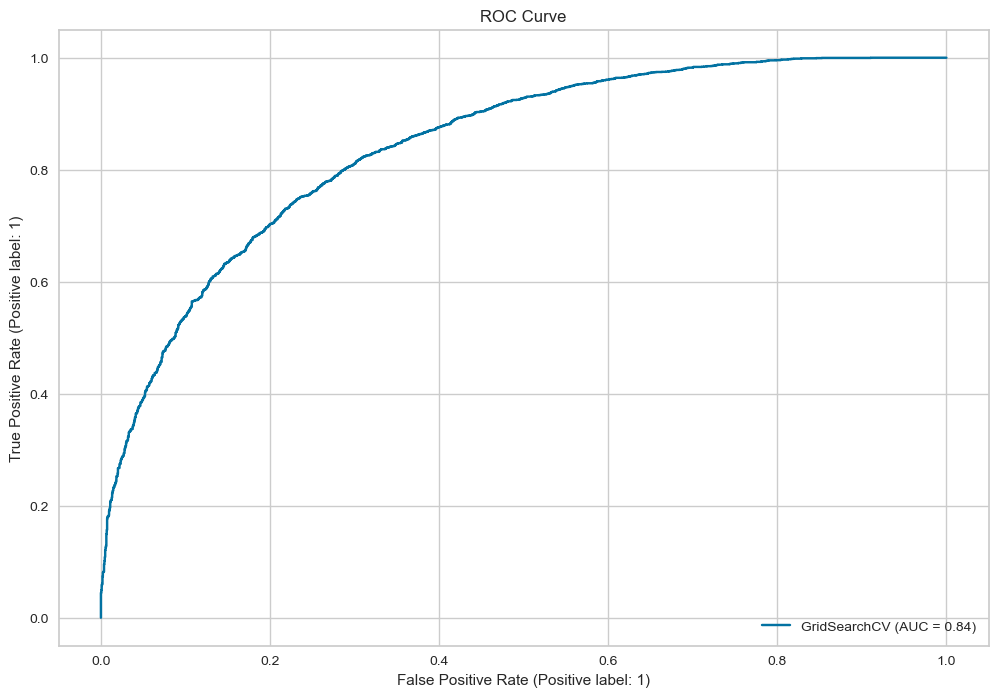

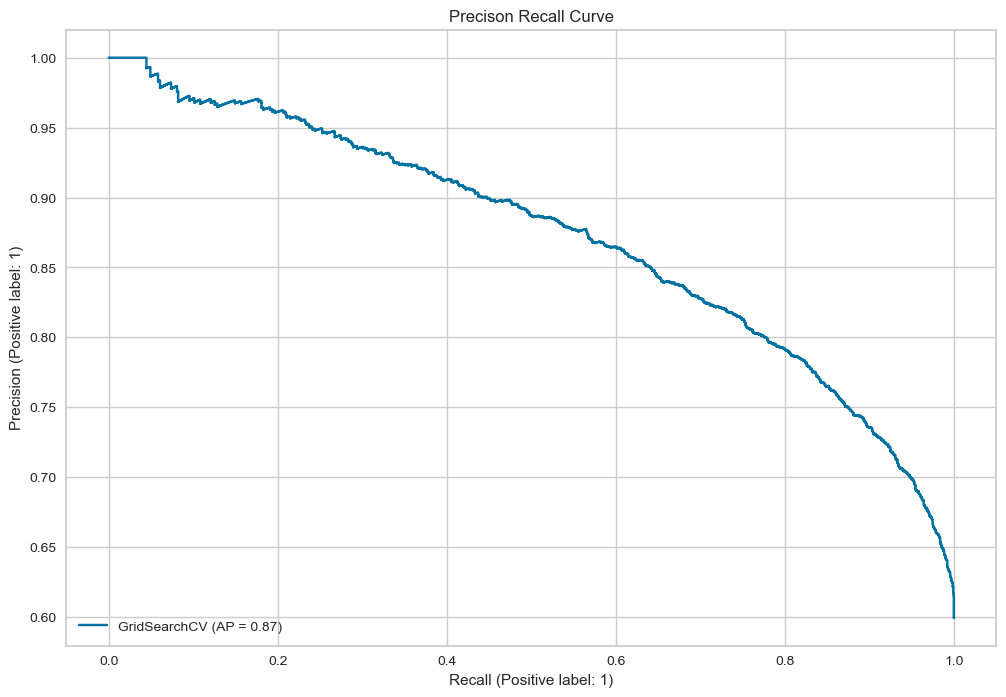

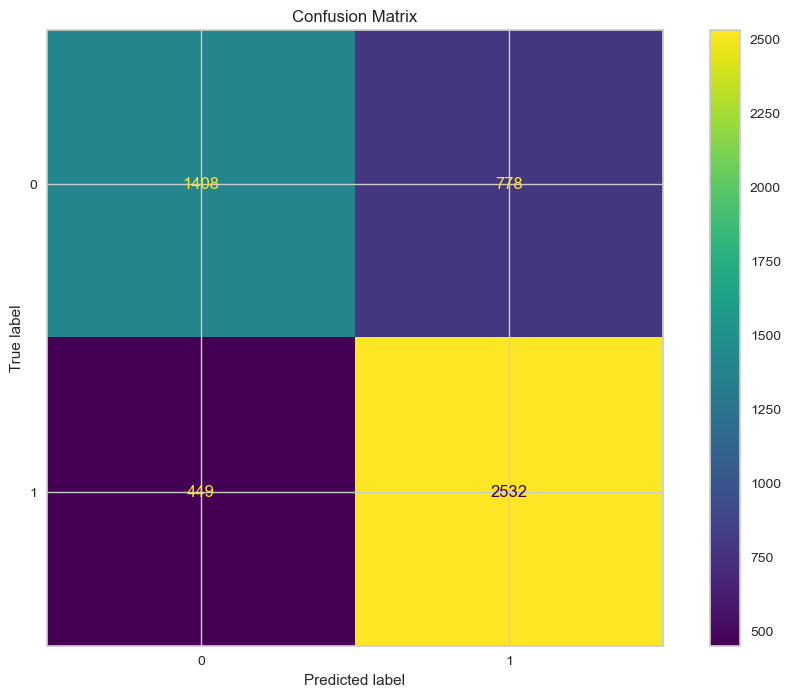

In [92]:
# Output best XGBoost parameter, ROC curve, precision_recall_curve and confusion matrix
print('Best hyperparameters:', grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Recall:", recall_score(y_test, y_pred))
plot_roc_curve(grid_search, X_test, y_test)
plt.title("ROC Curve")
plot_precision_recall_curve(grid_search, X_test, y_test)
plt.title("Precison Recall Curve")
plot_confusion_matrix(grid_search, X_test, y_test)
plt.title("Confusion Matrix")

In [85]:
# run best XGBoost 100 times to get histogram of recall
XGB_recall_100 = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    xgb_model = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 3, n_estimators = 300)
    xgb_model.fit(X_train, y_train);

    y_pred = xgb_model.predict(X_test)
    XGB_recall_100.append(recall_score(y_test, y_pred))

[Text(0.5, 1.0, 'Histogram of Recall using XGBoost')]

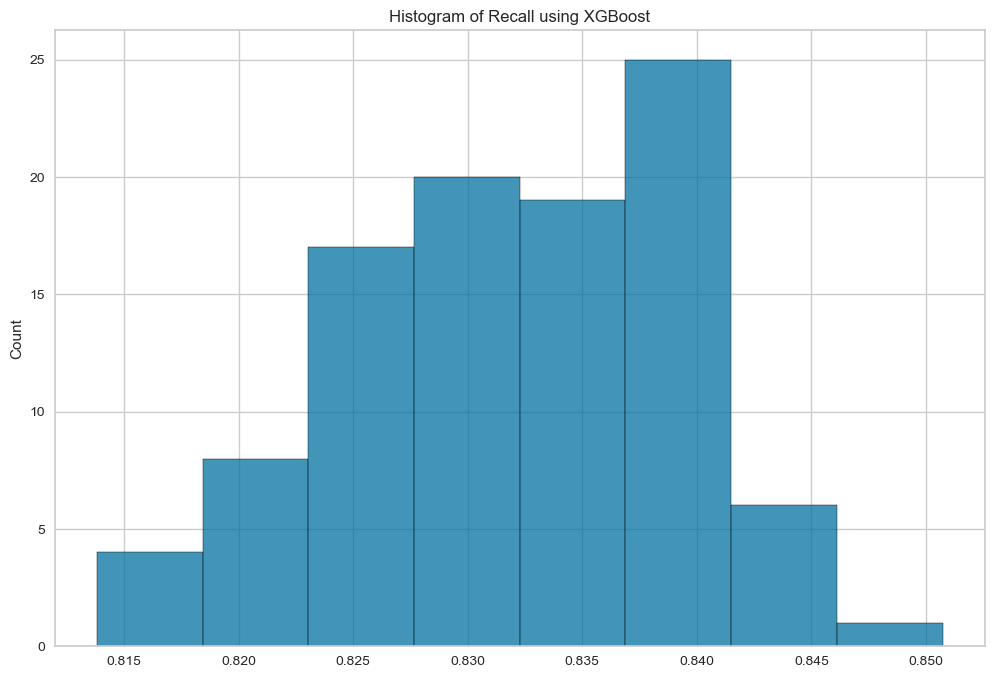

In [86]:
sns.histplot(XGB_recall_100).set(title='Histogram of Recall using XGBoost')

In [88]:
xg_hp = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

Text(0, 0.5, 'Feature')

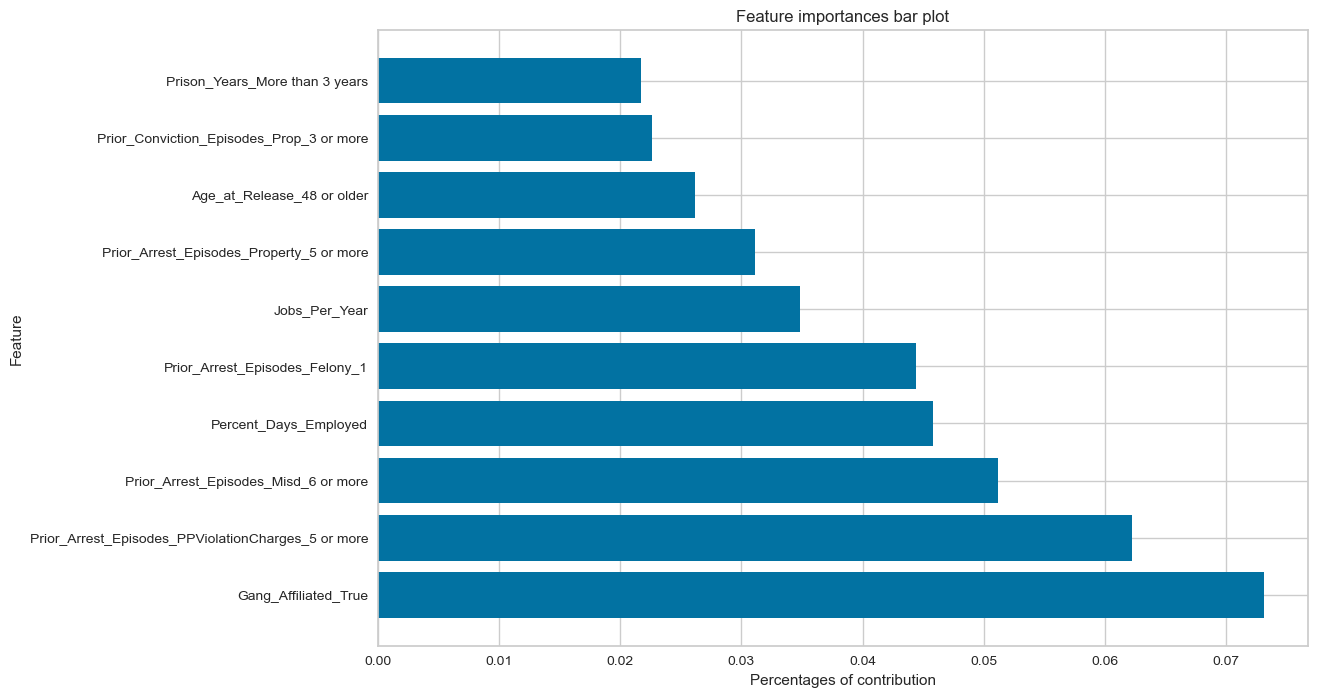

In [99]:
b = xg_hp.sort_values(by = "feature_importances", ascending = False)
plt.barh(b[:10].index,b[:10].feature_importances.values)
plt.title("Feature importances bar plot")
plt.xlabel("Percentages of contribution")
plt.ylabel("Feature")